# Exercise 0

This is a simple example on how to use Mad-X in Python to match a 10 m long FODO lattice. Each quadrupole is 1.5 m long.

In [2]:
!pwd
from cpymad.madx import Madx
madx = Madx()
import matplotlib.pyplot as plt
import numpy as np

get_ipython().run_line_magic('matplotlib','inline')
%config InlineBackend.figure_format = 'retina' # retina display

/Users/sterbini/CERNbox/2022/CAS/Sevrier2022/exercises/solutions/Exercise0

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.10 19:29:26      +
  ++++++++++++++++++++++++++++++++++++++++++++


### 1. Definition of the elements

For each element in the machine (dipole, quadrupole, sextupoles, solenoids,...) we can define its properties.

In [2]:
elementDefinition='''
/****Definition of elements****/
qfType:QUADRUPOLE, L=0.5, K1:=kf;
qdType:QUADRUPOLE, L=0.5, K1:=kd;
'''
madx.input(elementDefinition);

###  2. Definition of the sequence

This is a FODO cell.

In [3]:
sequenceDefinition='''
/****Definition of the sequence****/
fodo:SEQUENCE, REFER=exit, L=10;
qf: qfType, at=5;
qd: qdType, at=10;
ENDSEQUENCE;
'''
madx.input(sequenceDefinition);

### 3. Definition of the strenght

In [4]:
strengthDefinition='''
/****Definition of the strength****/
kf=+0.2985;
kd:=-kf;'''
madx.input(strengthDefinition);

### 4. Definition of the beam

In [5]:
beamDefinition='''
/****Definition of the beam****/
beam;
'''
madx.input(beamDefinition);

### Activation of the sequence

In [6]:
sequenceActivation='''
use, sequence=fodo;
'''
madx.input(sequenceActivation);

### Finding the periodic solution with the TWISS

In [7]:
madx.input('twiss;');

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.1173811911      -0.1230012214        19.73920011                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.1173811911 

               dq2            betymax              dymax              dyrms 
     -0.1230012214        19.73920011                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [8]:
# importing the twiss table in a pandas dataframe
myDF_BeforeMatching=madx.table.twiss.dframe()

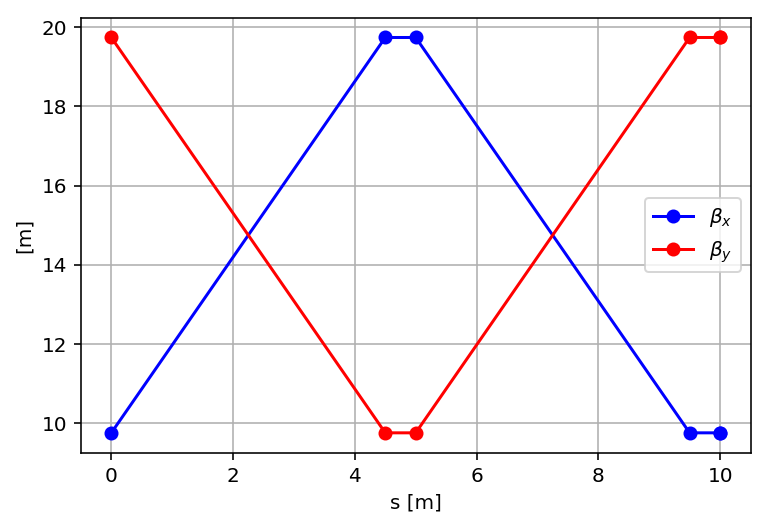

In [9]:
# plotting the results
plt.plot(myDF_BeforeMatching.s,myDF_BeforeMatching.betx,'o-b', label='$\\beta_x$')
plt.plot(myDF_BeforeMatching.s,myDF_BeforeMatching.bety,'o-r', label='$\\beta_y$')
plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

### Matching of the FODO cell
We match the cell for 90 deg phase advance.

In [10]:
matchingDefinition='''
/****Matching****/
MATCH, sequence=fodo;
  GLOBAL, Q1=.25;
  GLOBAL, Q2=.25;
  VARY, NAME=kf, STEP=0.00001;
  VARY, NAME=kd, STEP=0.00001;
  LMDIF, CALLS=50, TOLERANCE=1e-8;
ENDMATCH;'''
madx.input(matchingDefinition);

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   7.31865558e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kf                        5.85606e-01  2.98500e-01 -1.00000e+20  1.00000e+20
kd                       -5.85606e-01 -2.98500e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   7.31865558e-11


In [11]:
madx.input('twiss;')
myDF_AfterMatching=madx.table.twiss.dframe()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2500006038      -0.3182411001        16.26148602                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2500006061 

               dq2            betymax              dymax              dyrms 
     -0.3182411024        16.26148598                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

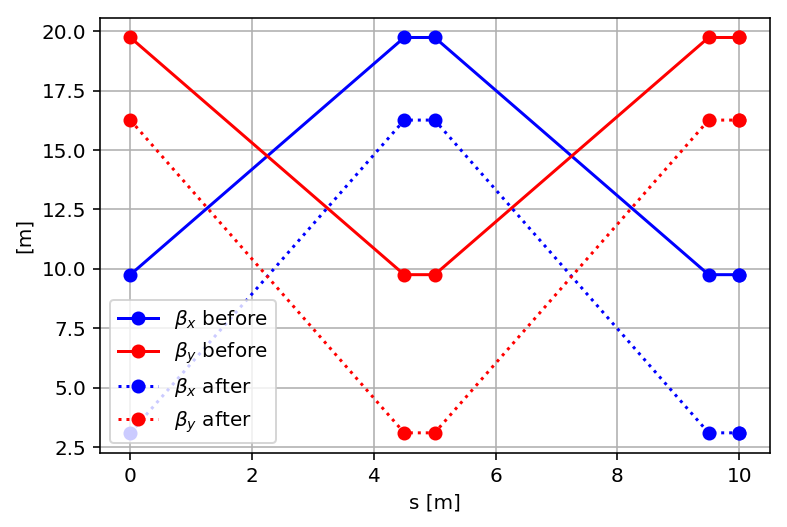

In [12]:
# plotting the results
# BM: before matching
plt.plot(myDF_BeforeMatching.s,myDF_BeforeMatching.betx,'o-b', label='$\\beta_x$ before')
plt.plot(myDF_BeforeMatching.s,myDF_BeforeMatching.bety,'o-r', label='$\\beta_y$ before')

# AM: after matching
plt.plot(myDF_AfterMatching.s,myDF_AfterMatching.betx,'o:b', label='$\\beta_x$ after')
plt.plot(myDF_AfterMatching.s,myDF_AfterMatching.bety,'o:r', label='$\\beta_y$ after')
plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

**Conclusion**: clearly we have reduced significantly the envelope of the beam!

### Comparison thin-thick approach
We match the thick lattice at 20,30,...150 deg and  plot K1 L vs Q1, Q2. We compare the results with the analytical formula in thin lens approximaition.

In [13]:
k1list=[]
Q1list=[]
for i in np.arange(20,160,10):
    print('\n===========================')
    matchingDefinition='''
    /****Matching****/
    option, echo=false;
    MATCH, sequence=fodo;
      GLOBAL, Q1='''+ str(i/360.) +''';
      GLOBAL, Q2='''+ str(i/360.)+''';
      VARY, NAME=kf, STEP=0.00001;
      VARY, NAME=kd, STEP=0.00001;
      LMDIF, CALLS=50, TOLERANCE=1e-8;
    ENDMATCH;'''
    madx.input(matchingDefinition);
    k1list.append(madx.elements.qfType.k1)
    Q1list.append(madx.table.summ.Q1[0])


START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.25145666e-12





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kf                        1.43795e-01  5.85606e-01 -1.00000e+20  1.00000e+20
kd                       -1.43795e-01 -5.85606e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.25145666e-12

START MATCHING

number of sequences: 1
sequence name: fodo
number of variables:    2
user given constraints: 1
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Targ

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in arcsin
  


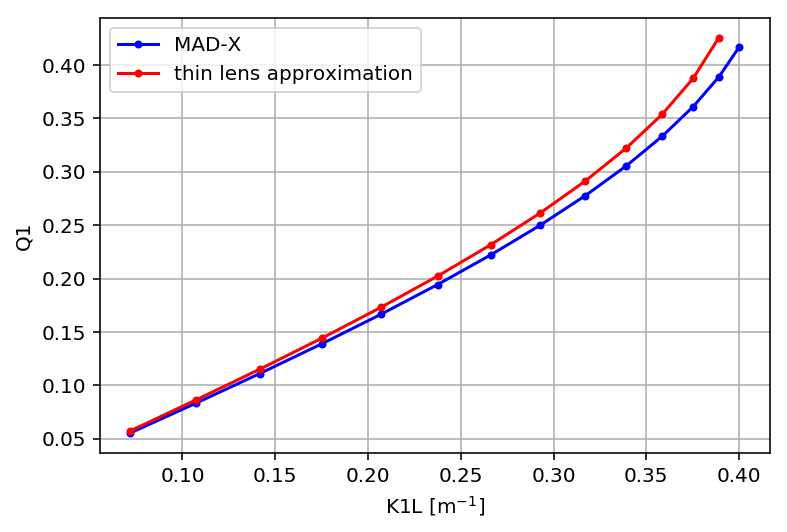

In [19]:
plt.plot(np.array(k1list)*madx.elements.qfType.l, Q1list,'.-b', label='MAD-X')
plt.grid()
plt.ylabel('Q1')
plt.xlabel('K1L [m$^{-1}$]')
f=1/np.array(k1list)/madx.elements.qfType.l
plt.plot(np.array(k1list)*madx.elements.qfType.l,np.arcsin(10/(4*f))/np.pi,'.-r', label='thin lens approximation')
plt.legend(loc='best')